In [1]:
from pydgrid import grid
from pydgrid.pydgrid import phasor2time, pq
from pydgrid.pf import pf_eval,time_serie
from pydgrid.electric import bess_vsc, bess_vsc_eval
from pydgrid.simu import simu, f_eval, ini_eval, run_eval
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('presentation.mplstyle') # copy simlink from this folder
%matplotlib notebook
colors_cycle=plt.rcParams.get('axes.prop_cycle')
colors = [item['color'] for item in colors_cycle]

In [26]:
  
data = {
"lines":[
		{"bus_j": "B1",  "bus_k": "B2",  "code": "UG1", "m": 50.0},
		{"bus_j": "B2",  "bus_k": "B3",  "code": "UG1", "m": 100.0}
		],
"buses":[
		{"bus": "B1",  "pos_x":  0,  "pos_y": 0, "units": "m", "U_kV":0.4},
		{"bus": "B2",  "pos_x":100,  "pos_y": 0, "units": "m", "U_kV":0.4},
		{"bus": "B3",  "pos_x":200,  "pos_y": 0, "units": "m", "U_kV":0.4}
		],
"grid_formers":[
		{"bus": "B1",
			"bus_nodes": [1, 2, 3, 4], "deg": [0, -120, -240, 0.0],
			"kV": [0.23, 0.23, 0.23, 0.0], "code":"bess_100kVA_300kWh"},
		{"bus": "B3",
			"bus_nodes": [1, 2, 3, 4], "deg": [0, -120, -240, 0.0],
			"kV": [0.23, 0.23, 0.23, 0.0], "code":"bess_100kVA_300kWh"},
		],
"grid_feeders":[{ "bus": "B2","bus_nodes": [1, 2, 3, 4],
					"kW": [-20.0, -20.0, -20.0], "kvar": [30.0,30.0,30.0],
					"kA": [0.0,0.0,0.0], "phi_deg":[-90, -90, -90]}
				],
"shunts":[
		{"bus": "B1" , "R": 1.0, "X": 0.0, "bus_nodes": [4,0]},
		{"bus": "B3" , "R": 1.0, "X": 0.0, "bus_nodes": [4,0]}
		],
"bess_vsc":{
            "bess_100kVA_300kWh":{"ctrl_mode":3, "s_n_kVA":100.0, "V_dc":800.0, 
                     "soc_max_kWh":300.0, "soc_ini_kWh":100.0, 
                     "source_mode":"grid_former", "L":1.0e-3, "R":1.0,
                     "R_0":0.1, "R_1":0.2, "C_1":100.0,
                     "K_v":0.02, "K_ang":0.02,"T_v":1, "T_ang":1 }
            },
"sim_params":{"Dt":0.01}
}



In [27]:
grid_1 = grid()
grid_1.read(data)  # Load data
simu_1 = simu(grid_1) 
grid_1.pf()  # solve power flow
simu_1.ini(0.0)
simu_1.run(1000)

In [28]:
def test():
    
    grid_1 = grid()
    grid_1.read(data)  # Load data
    simu_1 = simu(grid_1) 
    grid_1.pf()  # solve power flow
    simu_1.ini()
    simu_1.run(10)
    grid_1.params_pf['gfeed_powers'] = 2*grid_1.params_pf['gfeed_powers']
    simu_1.run(20)
    grid_1.params_pf['gfeed_powers'] = 0.5*grid_1.params_pf['gfeed_powers']
    simu_1.run(3600*24)
    
    return simu_1

# with numba only in pf: 4.62 s ± 21.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# with numba: 602 ms ± 5.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#%timeit test()
simu_1 = test()

<IPython.core.display.Javascript object>


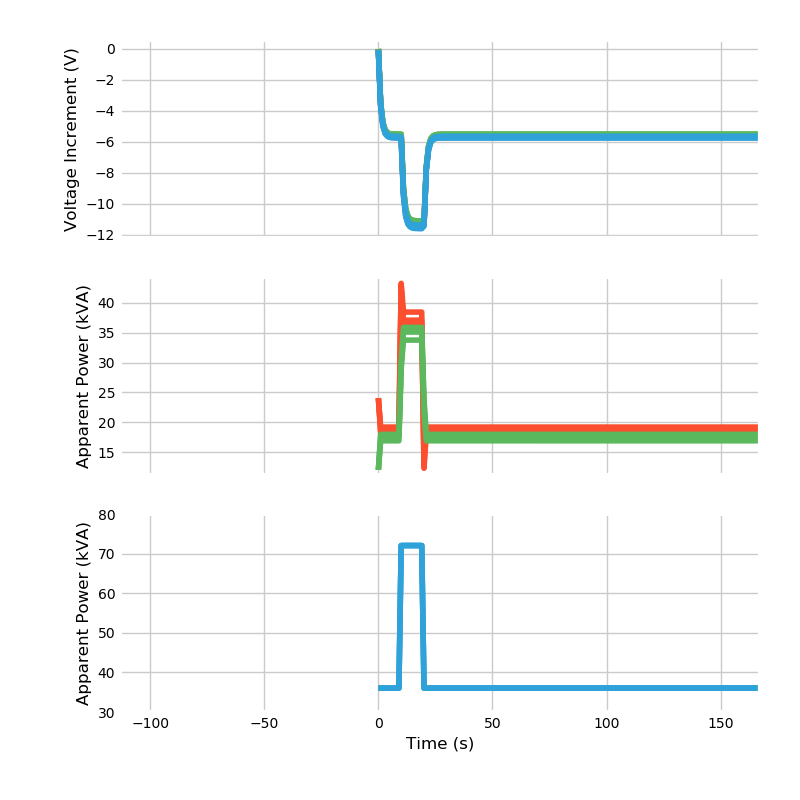

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 8), sharex = True)

S = simu_1.V_nodes*np.conj(simu_1.I_nodes)
V_abc_2_m = abs(simu_1.V_nodes[:,8:11])
dec = 100
T = simu_1.T[0::dec]
axes[0].plot(T, abs(simu_1.V_nodes[0::dec,0:3]) -230, colors[0])
axes[0].plot(T, abs(simu_1.V_nodes[0::dec,4:7]) -230, colors[1])
axes[0].plot(T, abs(simu_1.V_nodes[0::dec,8:11])-230, colors[2])

#axes[1].plot(T, S.real)
#axes[1].plot(T, S.imag)
axes[1].plot(T, np.abs(S[0::dec,0:3]/1000), colors[0])
axes[1].plot(T, np.abs(S[0::dec,4:7]/1000), colors[1])
axes[2].plot(T, np.abs(S[0::dec,8:11]/1000), colors[2])


#axes[0].set_ylabel('Y_1')
#axes[1].set_ylabel('Y_2')

for ax in axes:
    ax.grid(True)
#plt.xticks(rotation=30)
axes[0].set_ylabel('Voltage Increment (V)')
axes[1].set_ylabel('Apparent Power (kVA)')
axes[2].set_ylabel('Apparent Power (kVA)')
axes[2].set_xlabel('Time (s)')
#axes[0].set_ylim([222,231])
axes[2].set_ylim([30,80])
axes[2].ticklabel_format(useOffset=False)
#fig.savefig('out.svg', bbox_inches='tight')

<IPython.core.display.Javascript object>


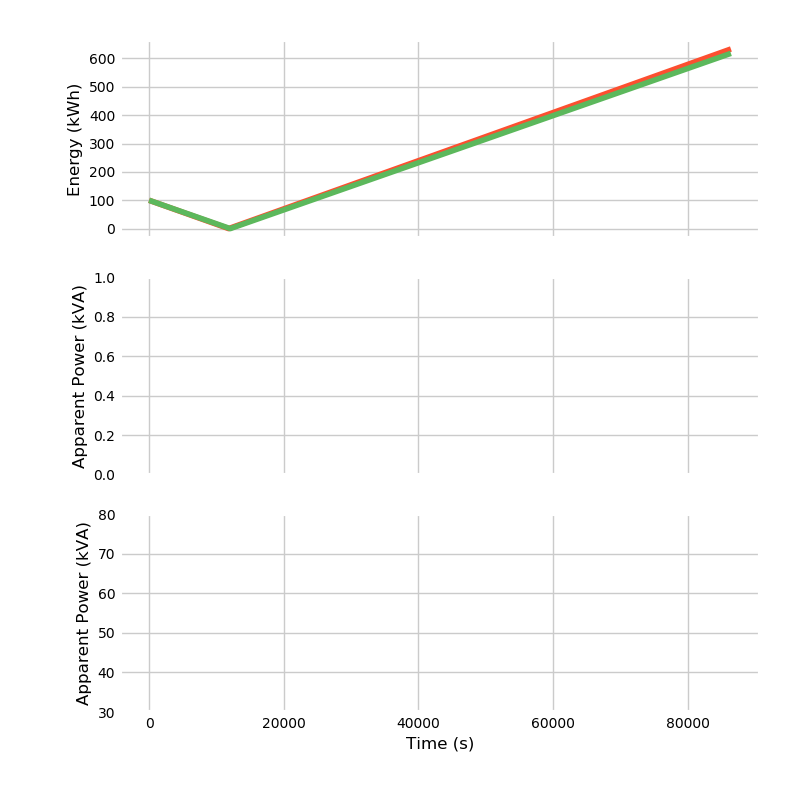

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 8), sharex = True)

dec = 100
T = simu_1.T[0::dec]
axes[0].plot(T, abs(simu_1.X[0::dec,0]/1000/3600))
axes[0].plot(T, abs(simu_1.X[0::dec,10]/1000/3600))



#axes[0].set_ylabel('Y_1')
#axes[1].set_ylabel('Y_2')

for ax in axes:
    ax.grid(True)
#plt.xticks(rotation=30)
axes[0].set_ylabel('Energy (kWh)')
axes[1].set_ylabel('Apparent Power (kVA)')
axes[2].set_ylabel('Apparent Power (kVA)')
axes[2].set_xlabel('Time (s)')
#axes[0].set_ylim([222,231])
axes[2].set_ylim([30,80])
axes[2].ticklabel_format(useOffset=False)
#fig.savefig('out.svg', bbox_inches='tight')

In [7]:
288*1000


288000